In [1]:
import collections
import os
import sys

import torch
import triton
import triton.language as tl

In [10]:
!nvidia-smi

Mon Jan 20 19:03:45 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              35W /  70W |    813MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
@triton.jit
def base_kernel(
    a_ptr,
    b_ptr,
    c_ptr,
    M,
    N,
    K,
    stride_am,
    stride_ak,
    stride_bk,
    stride_bn,
    stride_cm,
    stride_cn,
    GROUP_SIZE_M: tl.constexpr,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
):
    """Triton tutorial implementation of the kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    c = accumulator.to(tl.float16)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def matmul(a, b, kernel, kernel_params: dict):
    """
    Perform matrix multiplication using the provided matmul kernel.

    This is identical to the tutorial implementation, except that we allow for the option of passing in kernel
    parameters directly for later plotting (passing in GROUP_SIZE_M) purposes.

    :param a: input matrix A
    :param b: input matrix B
    :param kernel: the Triton matmul kernel to use
    :param kernel_params: kernel parameters
    """
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    # kernel_opts is used for plotting purposes (e.g, pass in GROUP_SIZE_M directly to matmul instead of to the matmul kernel through the autotuner)

    M, K = a.shape
    K, N = b.shape

    c = torch.empty((M, N), device=a.device, dtype=torch.float16)

    grid = lambda META: (triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]),)

    kernel[grid](
        a,
        b,
        c,
        M,
        N,
        K,
        a.stride(0),
        a.stride(1),
        b.stride(0),
        b.stride(1),
        c.stride(0),
        c.stride(1),
        **kernel_params,
    )

    return c

In [3]:
def estimate_optimal_conf() -> int:
    """
    Estimate the optimal configuration for matmul by autotuning with a subset of the K values (0, 8193).

    The autotuning process will produce an optimal configuration for each K in the subset.
    We do a greedy estimate by choosing the most frequent configuration across all K.
    The variance of our estimate decreases as we increase the subset size, among other factors.

    :return: the number of configurations used in the autotuning process
    """
    configs = []
    block_size_lst = [64, 128]
    GSM_lst = [4, 8]  # GROUP_SIZE_M
    ns_lst = [2, 3]  # num_stages
    nw_lst = [16, 32]  # num_warps
    for BSM in block_size_lst:
        for BSN in block_size_lst:
            for BSK in block_size_lst:
                for GSM in GSM_lst:
                    for ns in ns_lst:
                        for nw in nw_lst:
                            configs.append(
                                triton.Config(
                                    {
                                        "BLOCK_SIZE_M": BSM,
                                        "BLOCK_SIZE_N": BSN,
                                        "BLOCK_SIZE_K": BSK,
                                        "GROUP_SIZE_M": GSM,
                                    },
                                    num_stages=ns,
                                    num_warps=nw,
                                )
                            )

    # set kernel to be autotunable with the above configs
    auto_kernel = triton.autotune(configs=configs, key=["K"])(base_kernel)

    bench = triton.testing.Benchmark(
        x_names=["K"],
        x_vals=[i for i in range(1024, 8193, 1024)],
        line_arg="provider",
        line_vals=["cublas", "triton"],
        line_names=["cuBLAS", "Triton"],
        styles=[("blue", "-"), ("red", "-")],
        ylabel="runtime (ms)",
        plot_name=f"autotuned-matmul-fp16",
        args={"M": 8192, "N": 8192},
    )

    @triton.testing.perf_report(bench)
    def benchmark(M, N, K, provider):
        a = torch.randn((M, K), device="cuda", dtype=torch.float16)
        b = torch.randn((K, N), device="cuda", dtype=torch.float16)

        if provider == "cublas":
            mean_ms = triton.testing.do_bench(lambda: torch.matmul(a, b))
        elif provider == "triton":
            mean_ms = triton.testing.do_bench(lambda: matmul(a, b, auto_kernel, {}))
        elif provider == "cutlass":
            raise NotImplementedError

        return mean_ms

    benchmark.run(print_data=True, show_plots=True, save_path="./estimate_optimal_conf")
    return len(configs)

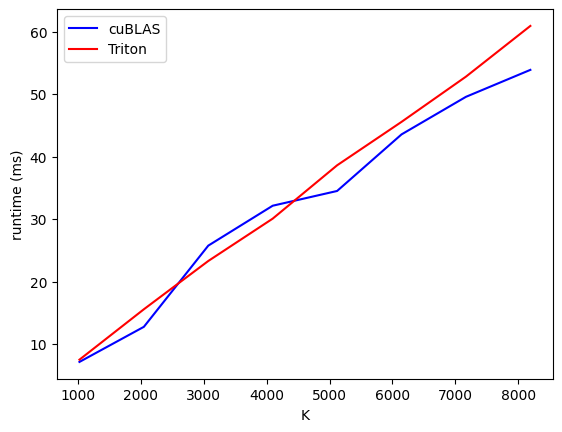

<Figure size 640x480 with 0 Axes>

In [4]:
stdout = sys.stdout
with open("autotuning_output", "w") as sys.stdout:
    os.environ["TRITON_PRINT_AUTOTUNING"] = "1"
    num_configs = estimate_optimal_conf()

sys.stdout = stdout  # reset stdout

In [6]:
def extract_config(line: str) -> tuple[dict, dict]:
    """
    Extract the meta and compilation parameters from a line in the autotuning output.

    :param line: a line in the autotuning output
    :return: two dictionaries containing the meta and compilation parameters
    """
    # find the start and end of the meta parameters
    meta_start = line.find("BLOCK_SIZE_M")
    meta_end = line.find("num_warps") - 2

    # find the start and end of the compilation parameters
    comp_start = meta_end + 2
    comp_end = len(line) - 2

    meta = line[meta_start:meta_end].split(", ")
    comp = line[comp_start:comp_end].split(", ")

    meta_dct = {}
    for param_val in meta:
        param, val = param_val.split(": ")
        meta_dct[param] = int(val)

    comp_dct = {}
    for param_val in comp:
        param, val = param_val.split(": ")
        comp_dct[param] = None if val == "None" else int(val)

    return meta_dct, comp_dct


def get_most_freq_config(file_path: str, num_configs: int) -> tuple[triton.Config, int]:
    """
    Get the most frequent configuration from the autotuning output.

    :param file_path: the path to the autotuning output
    :param num_configs: the number of configurations contained in the file
    :return: the most frequent Triton configuration, excluding GROUP_SIZE_M
    """
    config_counter = collections.Counter()
    with open(file_path, "r") as f:
        for i, line in enumerate(f):
            if i >= num_configs:
                break
            config_counter[line] += 1

    most_freq, _ = config_counter.most_common(1)[0]

    print(f"Most frequent config: {most_freq}")

    meta_dct, comp_dct = extract_config(most_freq)
    gsm = meta_dct["GROUP_SIZE_M"]
    del meta_dct["GROUP_SIZE_M"]

    return triton.Config(meta_dct, **comp_dct), gsm

In [7]:
optimal_config, optimal_gsm = get_most_freq_config("autotuning_output", num_configs)

Most frequent config: Triton autotuning for function base_kernel finished after 36.11s; best config selected: BLOCK_SIZE_M: 128, BLOCK_SIZE_N: 128, BLOCK_SIZE_K: 64, GROUP_SIZE_M: 8, num_warps: 16, num_ctas: 1, num_stages: 2, maxnreg: None;



In [8]:
def plot_near_optimal(optimal_conf: triton.Config) -> None:
    """
    Plot the performance of the matmul kernel for different GROUP_SIZE_M values.

    The plots will include the optimal GROUP_SIZE_M found in the autotuning process; the intent is to show the
    behaviour of the kernel near the (estimated) optimal GROUP_SIZE_M.

    :param optimal_conf: the optimal configuration found in the autotuning process, excludes GROUP_SIZE_M
    """

    # We set the configuration of the kernel using an autotuner with one config; Triton does not seem to provide another way
    optimal_kernel = triton.autotune(configs=[optimal_conf], key=["M", "N"])(base_kernel)  # static

    benches = [
        triton.testing.Benchmark(
            x_names=["K"],
            x_vals=[i for i in range(1024, 8193, 1024)],
            line_arg="provider",
            line_vals=["cublas", "triton"],
            line_names=["cuBLAS", "Triton"],
            styles=[("green", "-"), ("blue", "-")],
            ylabel="Time (ms)",
            plot_name=f"GSM{GSM}-optimal-matmul-performance-fp16",
            args={
                "M": 8192,
                "N": 8192,
                "GSM": GSM,
            },
        )
        for GSM in list({optimal_gsm - 2 * i for i in range(3)} | {optimal_gsm + 2 * i for i in range(3)})
    ]

    @triton.testing.perf_report(benches)
    def benchmark(M, N, K, GSM, provider):
        a = torch.randn((M, K), device="cuda", dtype=torch.float16)
        b = torch.randn((K, N), device="cuda", dtype=torch.float16)

        if provider == "cublas":
            mean_ms = triton.testing.do_bench(lambda: torch.matmul(a, b))
        elif provider == "triton":
            mean_ms = triton.testing.do_bench(lambda: matmul(a, b, optimal_kernel, {"GROUP_SIZE_M": GSM}))
        elif provider == "cutlass":
            raise NotImplementedError

        return mean_ms

    benchmark.run(print_data=True, show_plots=True, save_path="./optimal_perf")

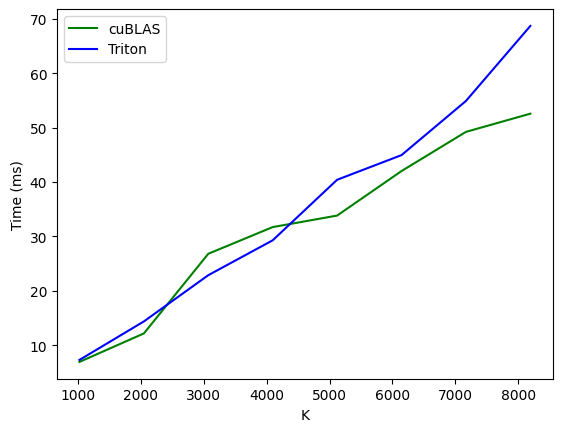

GSM4-optimal-matmul-performance-fp16:
        K     cuBLAS     Triton
0  1024.0   6.930717   7.295331
1  2048.0  12.166548  14.374899
2  3072.0  26.811823  22.874357
3  4096.0  31.719978  29.288330
4  5120.0  33.835503  40.416046
5  6144.0  42.023567  44.951218
6  7168.0  49.223648  54.904770
7  8192.0  52.569920  68.701920


<Figure size 640x480 with 0 Axes>

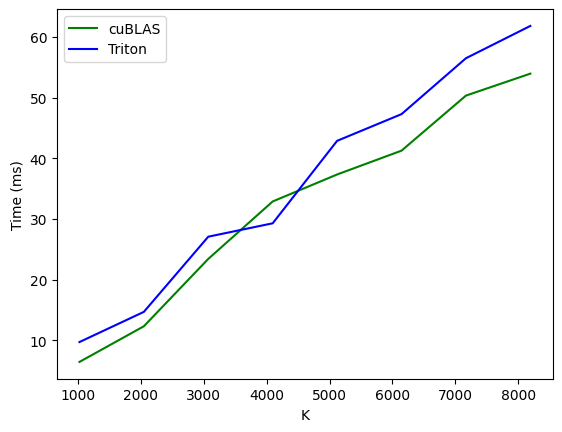

GSM6-optimal-matmul-performance-fp16:
        K     cuBLAS     Triton
0  1024.0   6.449773   9.724880
1  2048.0  12.329227  14.702606
2  3072.0  23.433289  27.096182
3  4096.0  32.904175  29.303169
4  5120.0  37.352528  42.898415
5  6144.0  41.279747  47.301105
6  7168.0  50.356255  56.516640
7  8192.0  53.977951  61.843361


<Figure size 640x480 with 0 Axes>

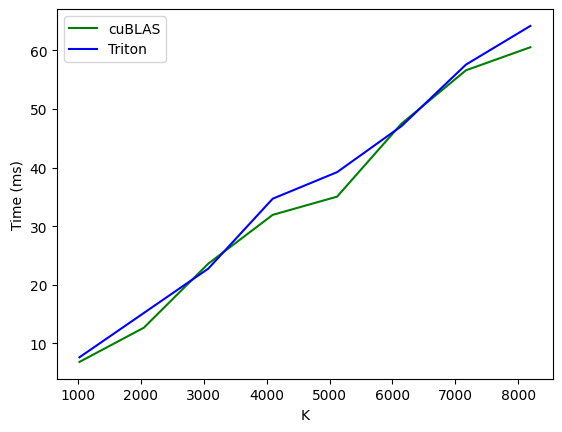

GSM8-optimal-matmul-performance-fp16:
        K     cuBLAS     Triton
0  1024.0   6.822262   7.611436
1  2048.0  12.664480  15.177881
2  3072.0  23.599247  22.747904
3  4096.0  31.925484  34.681442
4  5120.0  35.037453  39.219681
5  6144.0  47.502029  47.082191
6  7168.0  56.602753  57.575073
7  8192.0  60.539711  64.180161


<Figure size 640x480 with 0 Axes>

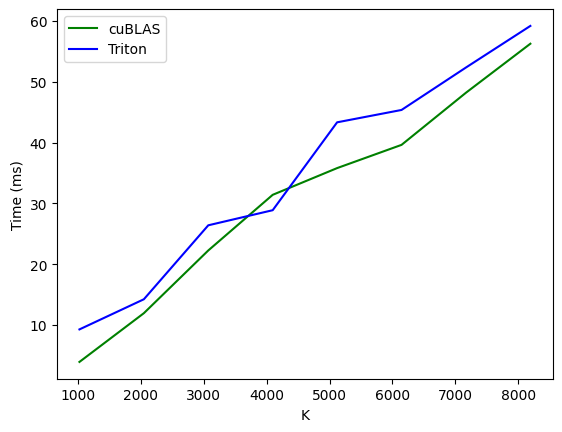

GSM10-optimal-matmul-performance-fp16:
        K     cuBLAS     Triton
0  1024.0   3.922835   9.272496
1  2048.0  11.942128  14.231763
2  3072.0  22.261543  26.401169
3  4096.0  31.415125  28.884939
4  5120.0  35.812355  43.344288
5  6144.0  39.633934  45.378174
6  7168.0  48.211967  52.359711
7  8192.0  56.274719  59.204769


<Figure size 640x480 with 0 Axes>

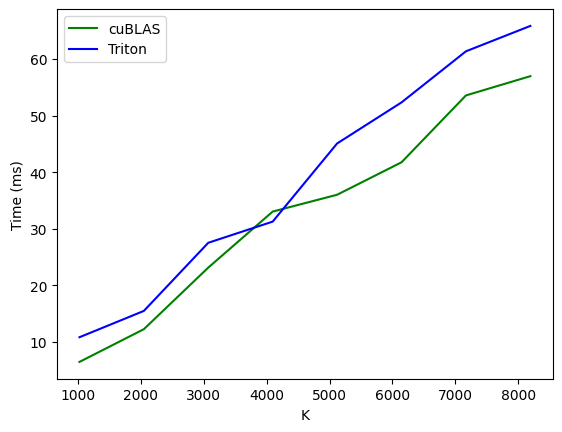

GSM12-optimal-matmul-performance-fp16:
        K     cuBLAS     Triton
0  1024.0   6.501674  10.859392
1  2048.0  12.282026  15.509824
2  3072.0  23.159584  27.542528
3  4096.0  33.053810  31.282005
4  5120.0  36.023537  45.078785
5  6144.0  41.757133  52.332928
6  7168.0  53.563488  61.353951
7  8192.0  56.964447  65.837379


<Figure size 640x480 with 0 Axes>

In [9]:
os.environ["MLIR_ENABLE_DUMP"] = "1"
os.environ["TRITON_ALWAYS_COMPILE"] = "1"
os.environ["LLVM_IR_ENABLE_DUMP"] = "1"
plot_near_optimal(optimal_config)